Using CNNs to Predict the Output of Chemical Simulation under Uncertainty

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, LSTMConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

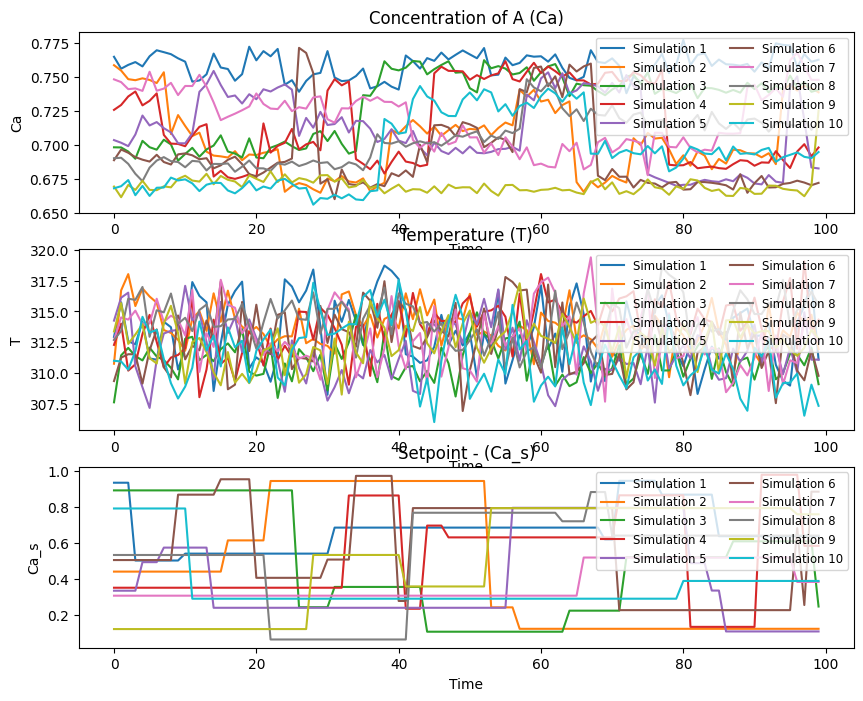

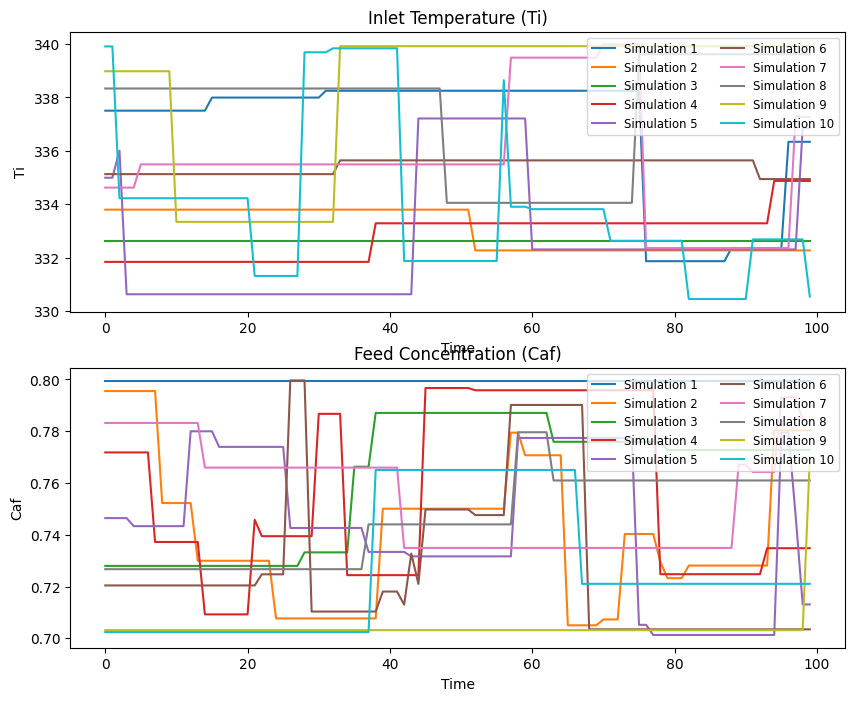

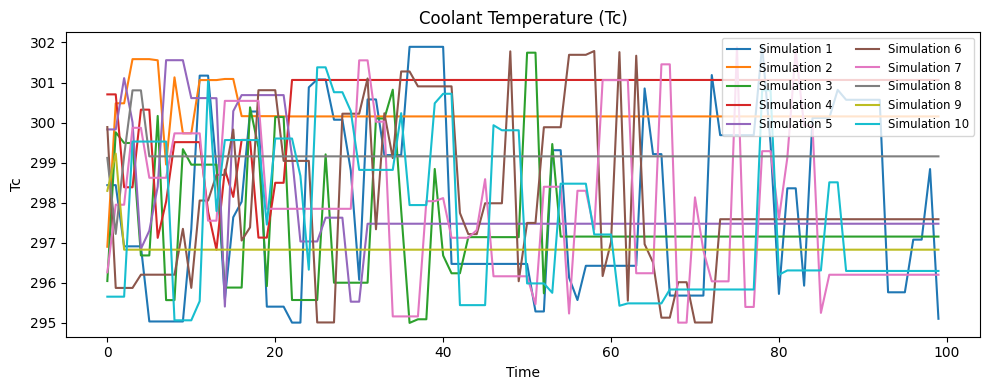

In [2]:
# Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period
CSTR_Config = SimulationConfig(n_simulations=10,
                                T = 101,
                                tsim = 500,
                                noise_percentage=0.005,
                            ) 
simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [3]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction CNN, defining the configuration for the model.

In [5]:
MLP_Config = MLPConfig(
    hidden_dim = 64,
    num_layers = 2,
    dropout = 0.1,
    activation = 'ReLU'
    )

model = MLP(
    config = MLP_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
    var = True,
)

# Train the model
criterion = nn.GaussianNLLLoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

model.eval()
with torch.no_grad():
    train_mean, train_var = model(X_train)
    test_mean, test_var = model(X_test)
    
scaler = data_processor.target_scaler

# Unscale the mean and variance. The variance must be multiplied by the
# square of the scaling factor, assumung the data is a normally distributed
# random variable

rescaled_train_pred = data_processor.process_model_output(train_mean, train_var)
train_mean = rescaled_train_pred.mean
train_var = rescaled_train_pred.variance

rescaled_test_pred = data_processor.process_model_output(test_mean, test_var)
test_mean = rescaled_test_pred.mean
test_var = rescaled_test_pred.variance


y_train_orig, y_test_orig = scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)

RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 1

Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

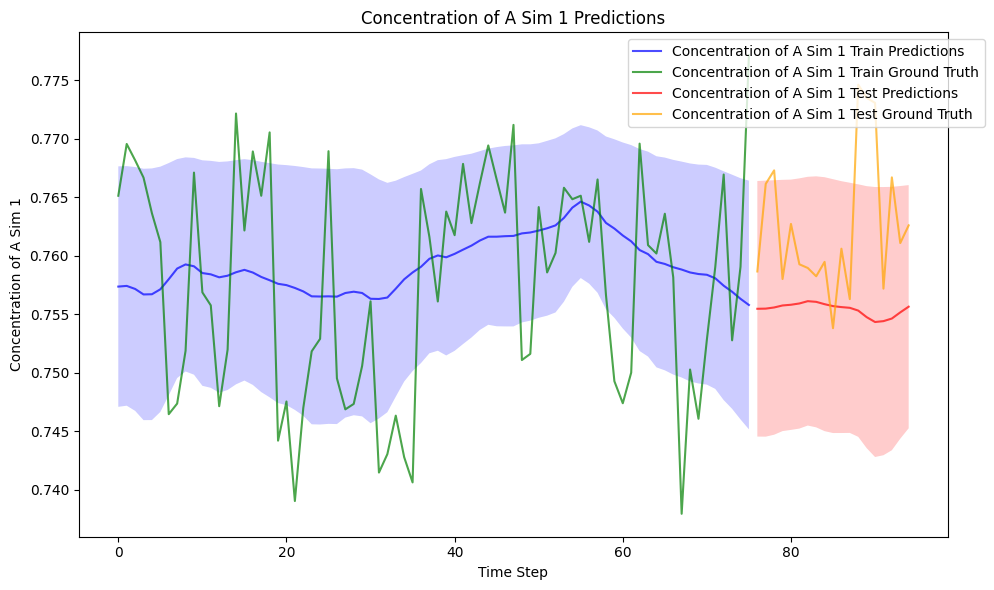

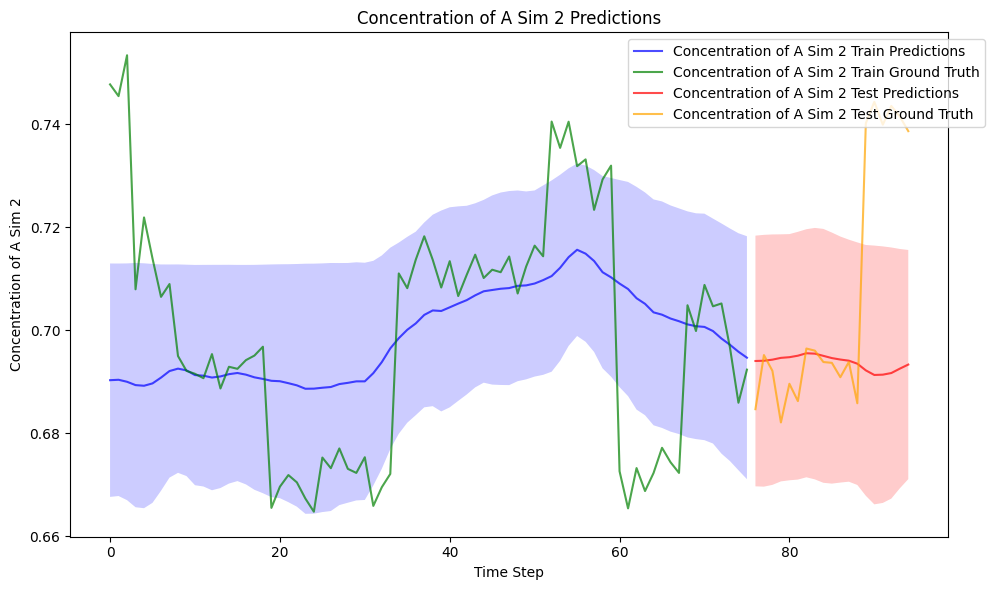

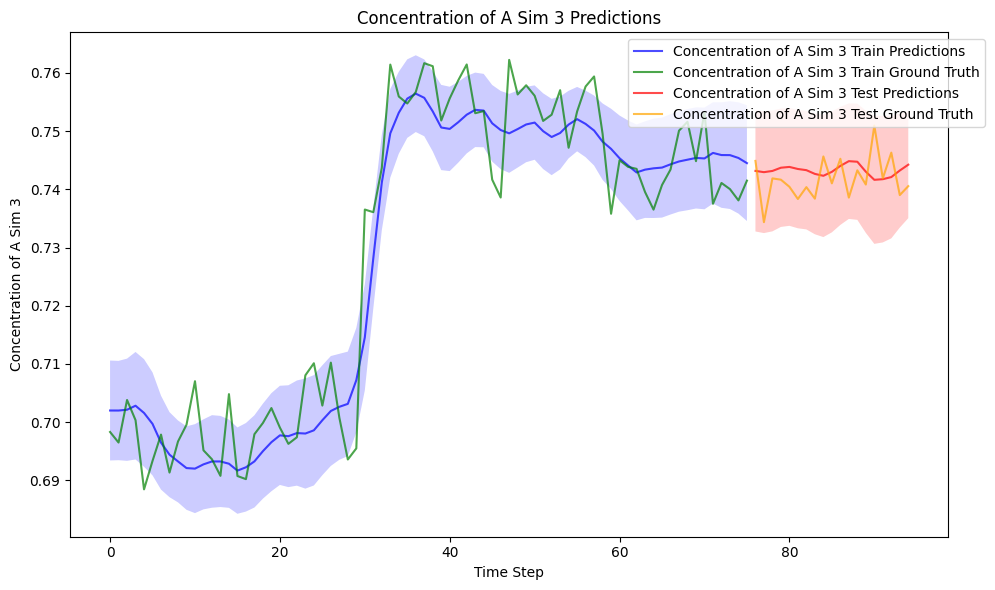

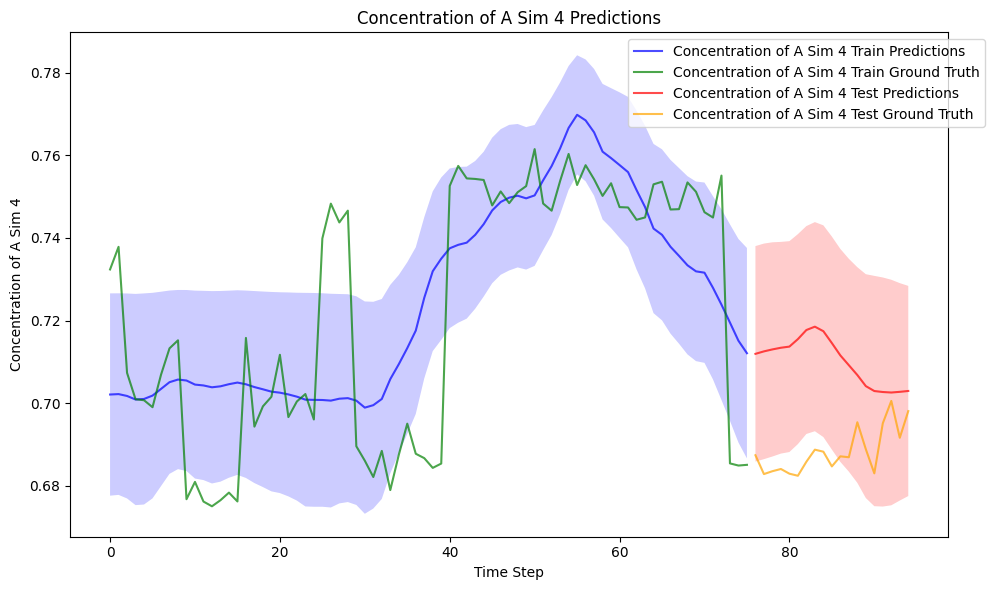

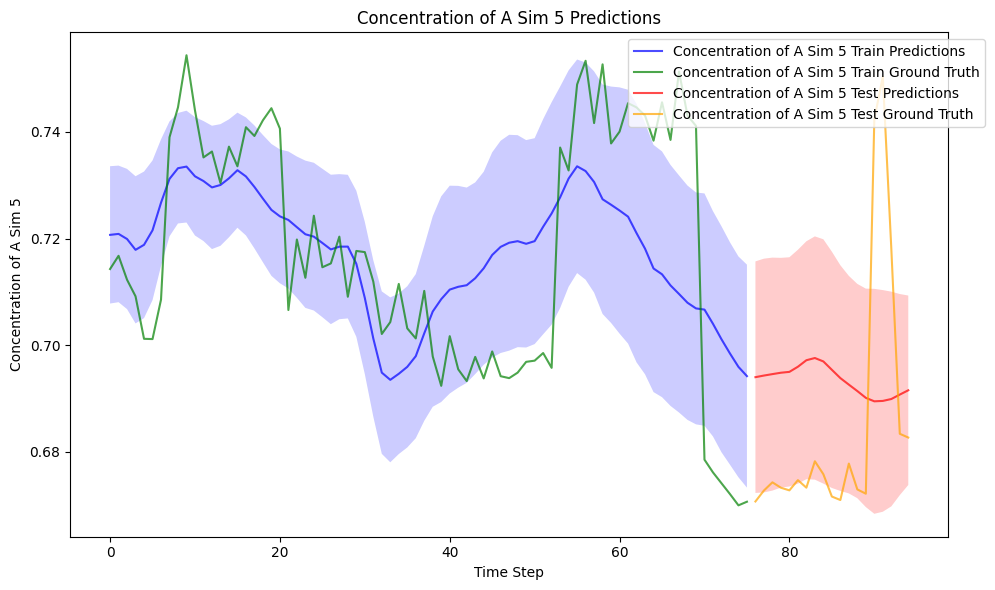

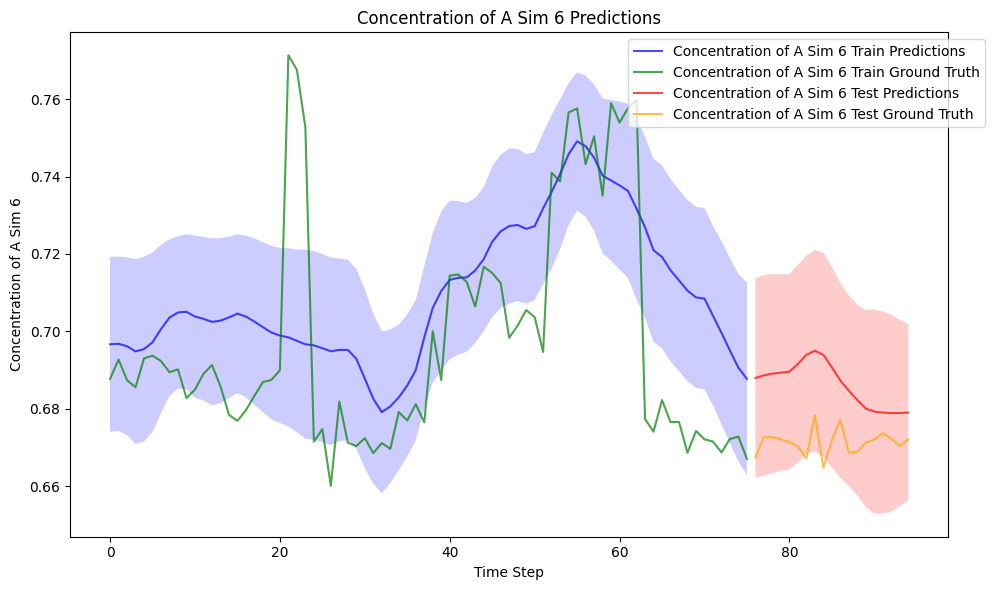

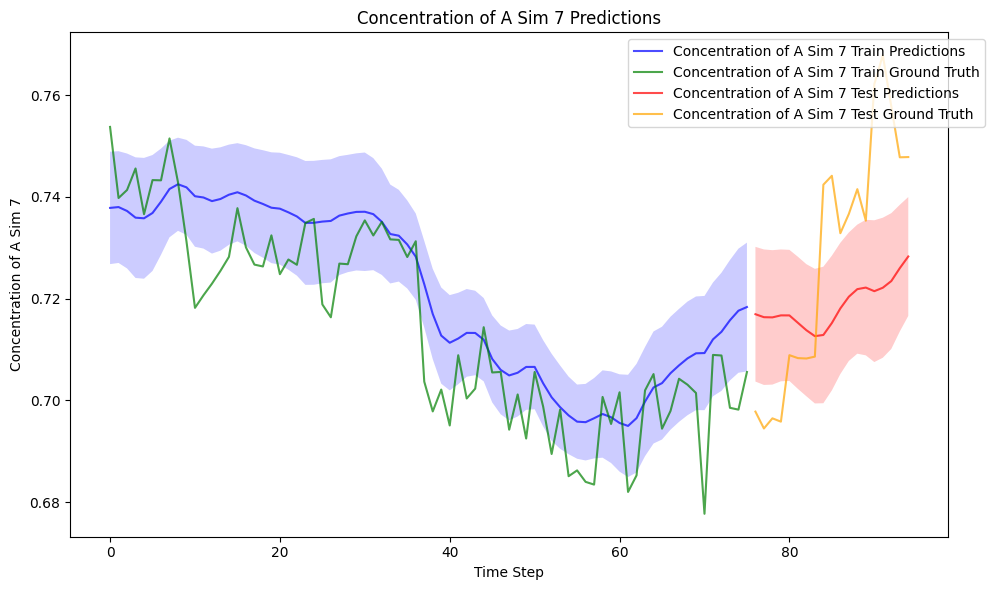

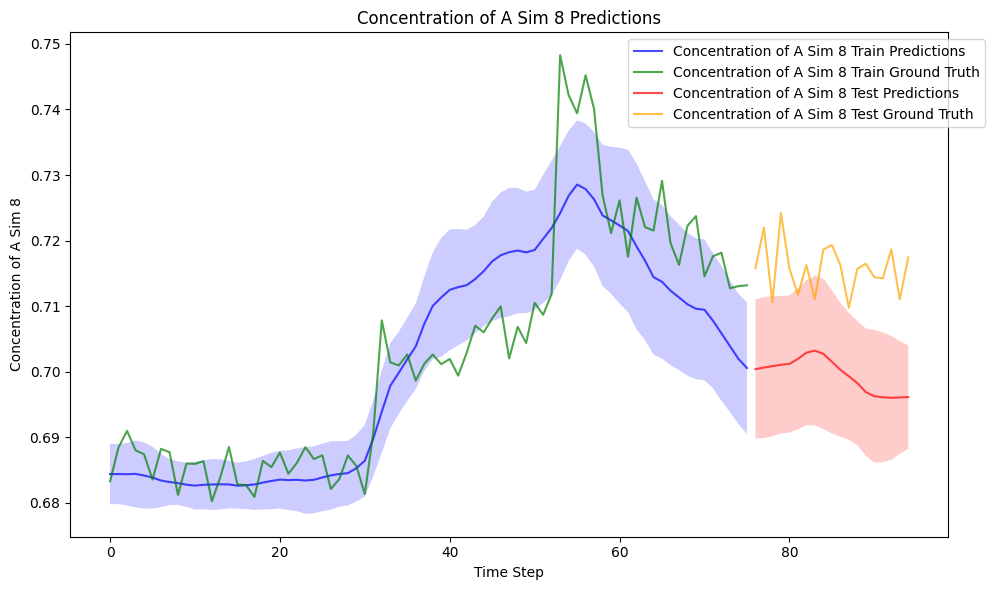

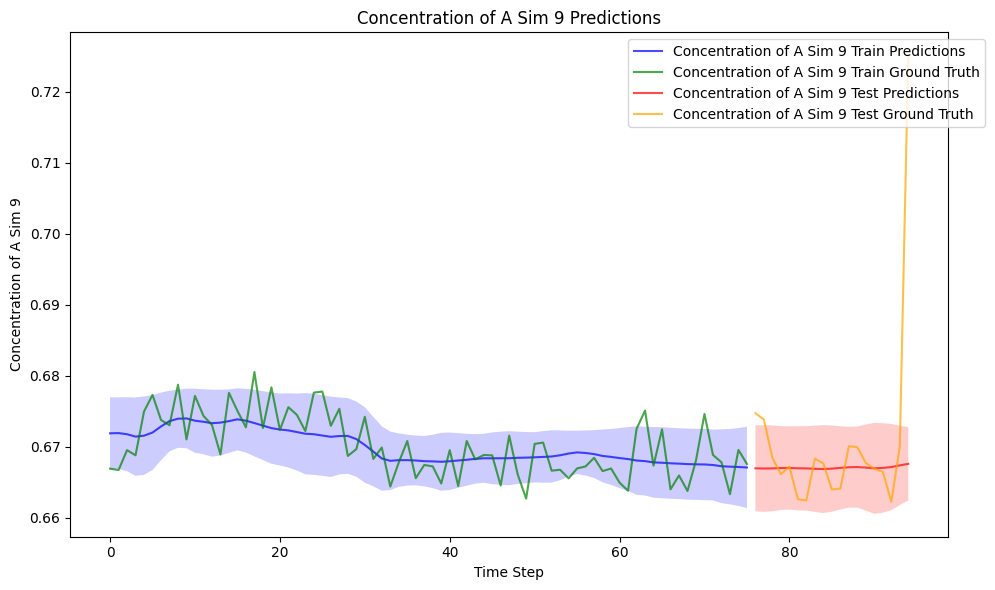

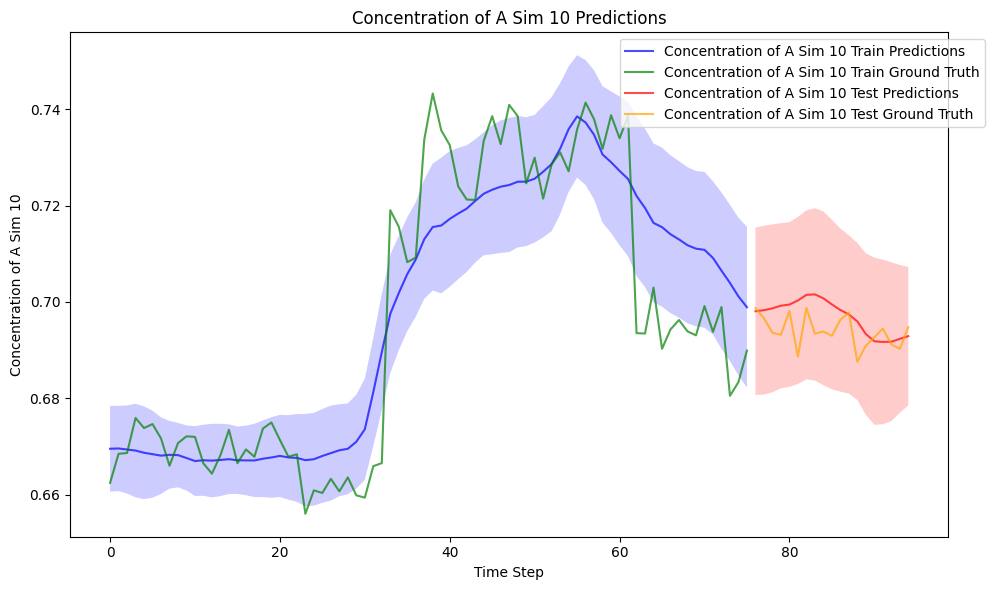

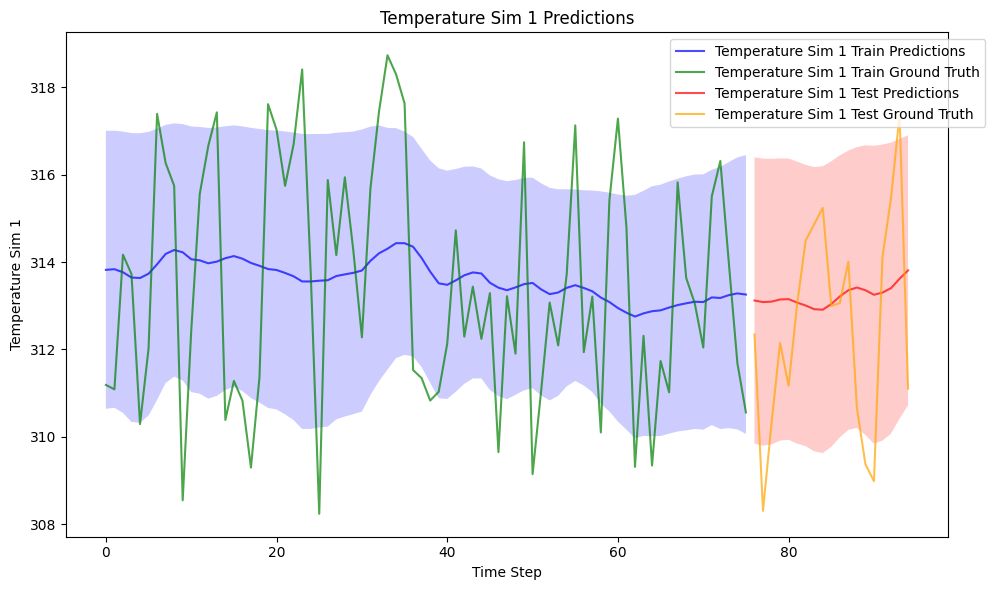

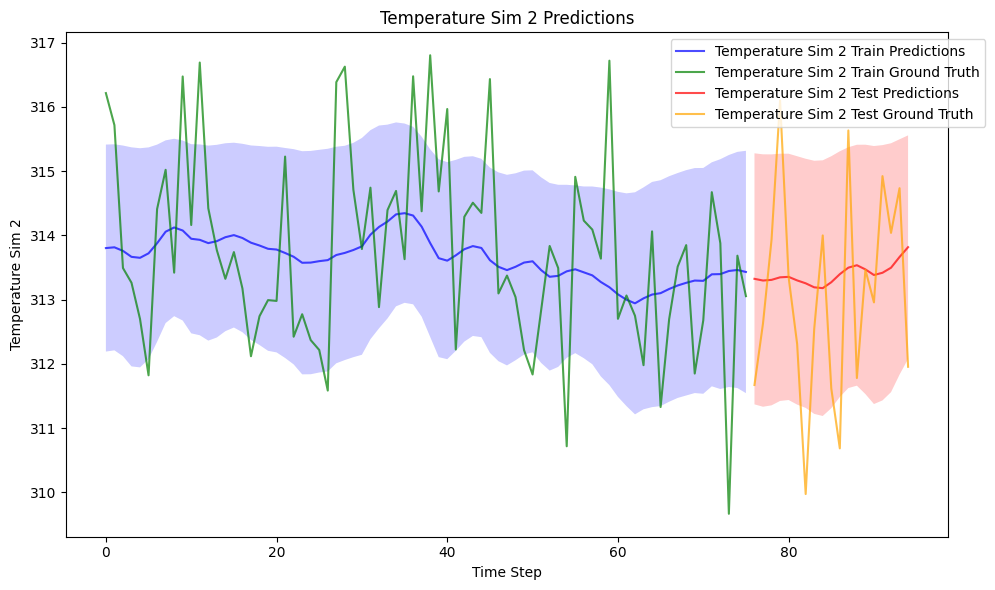

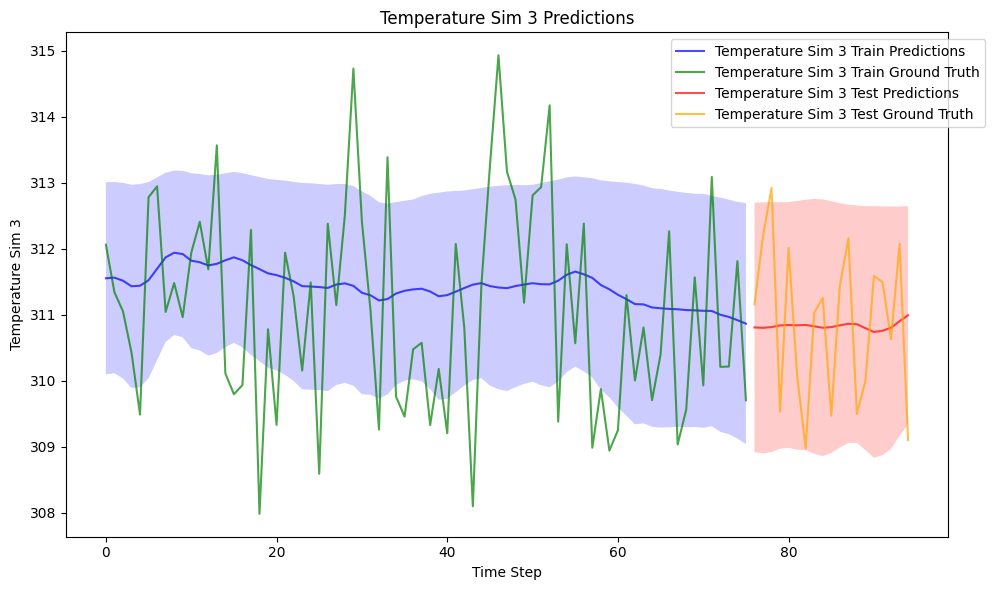

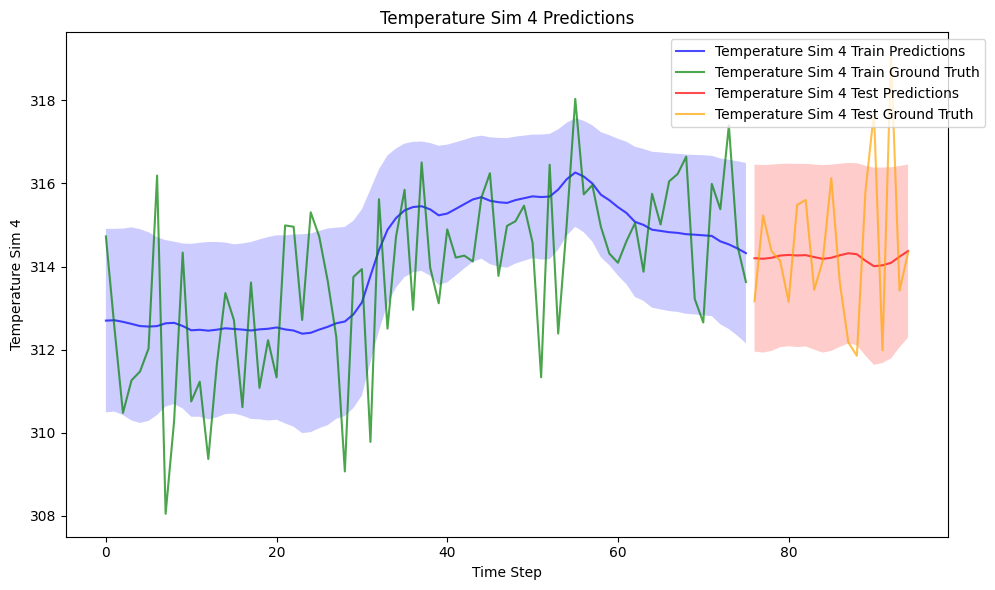

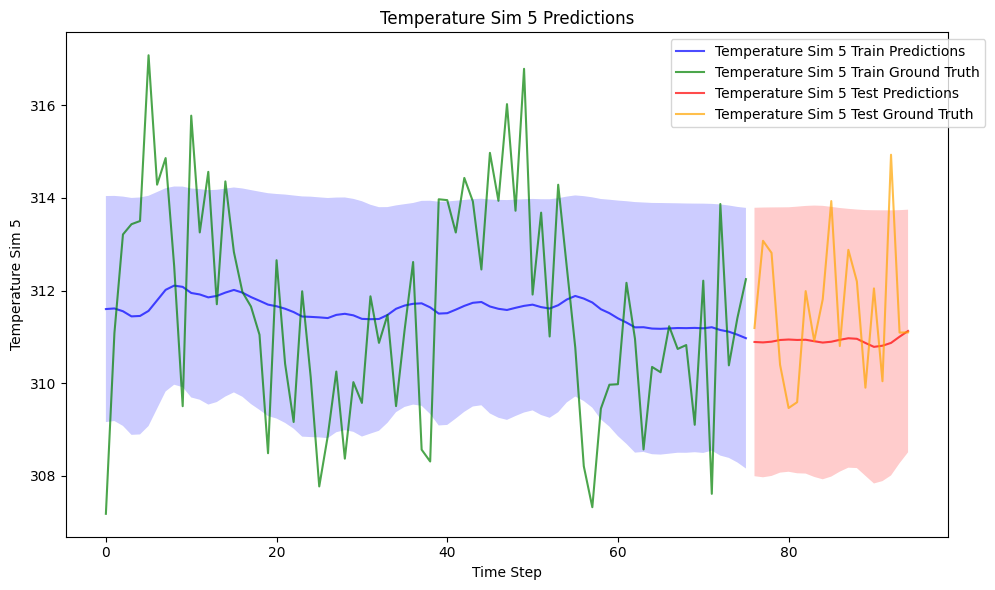

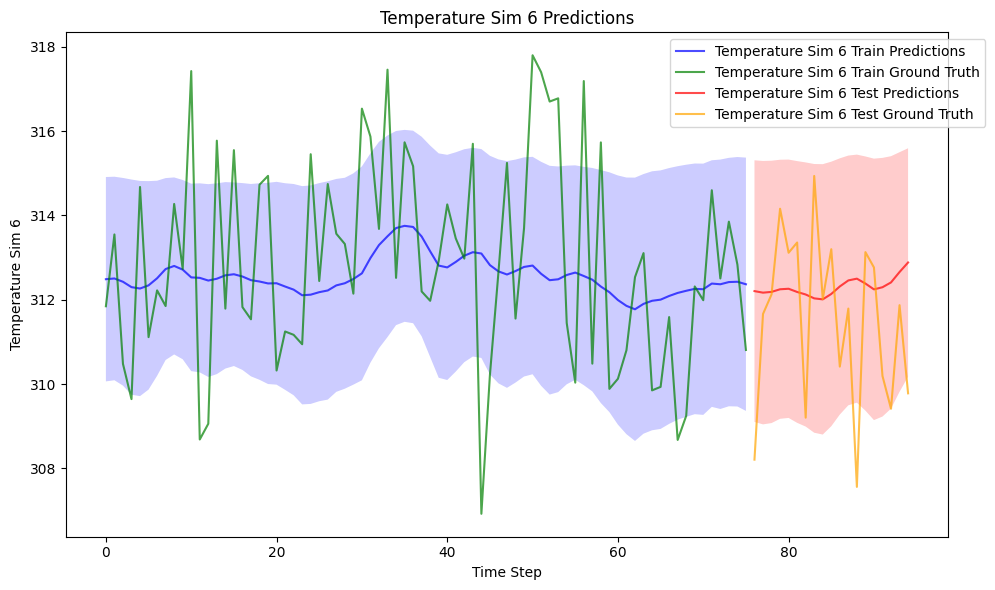

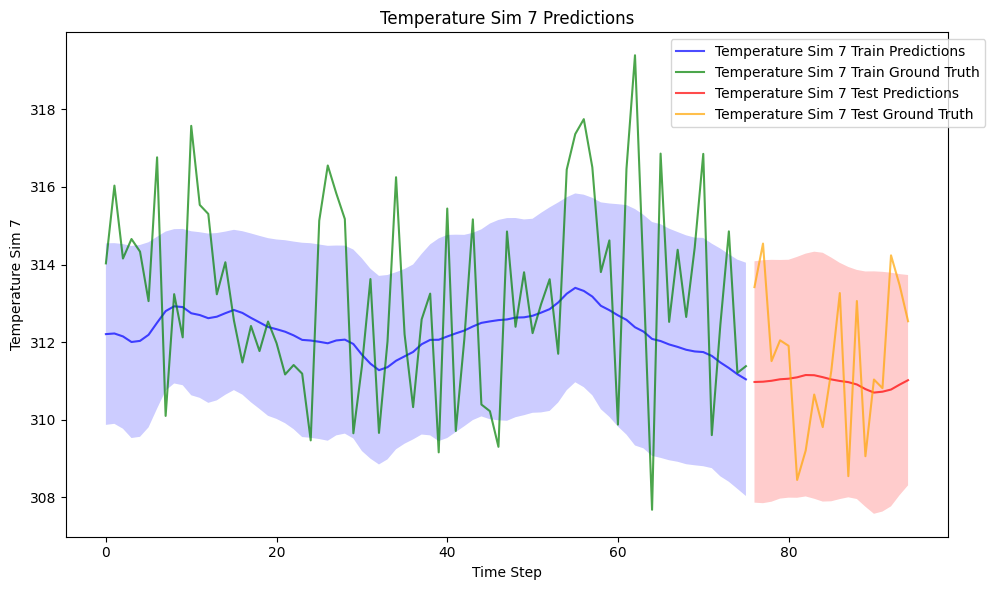

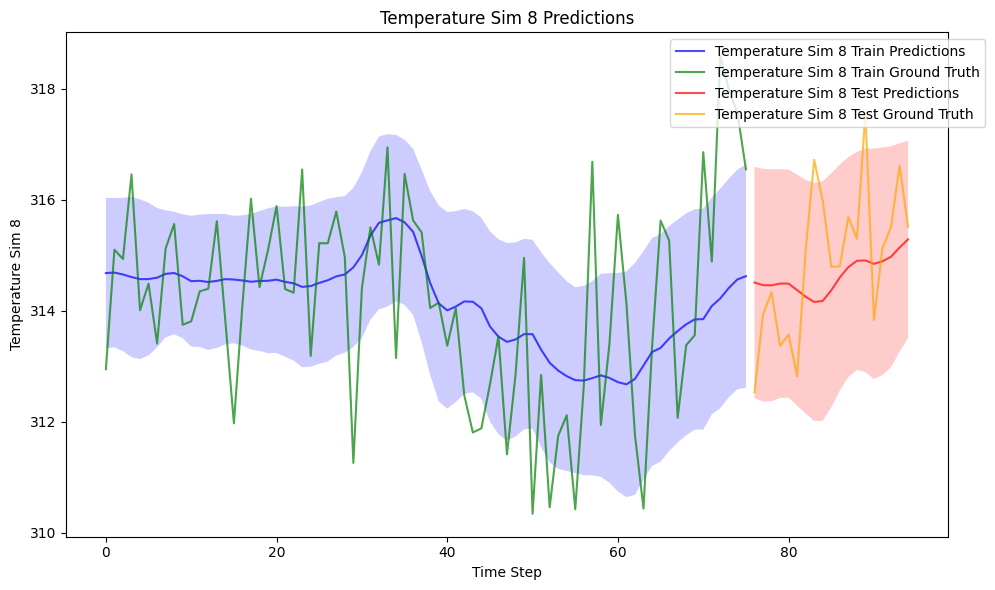

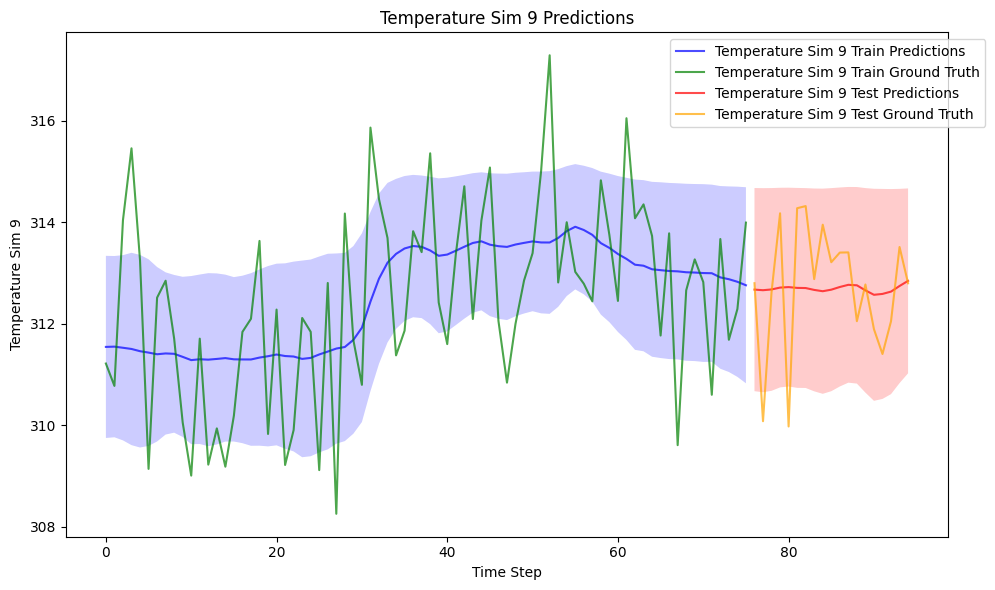

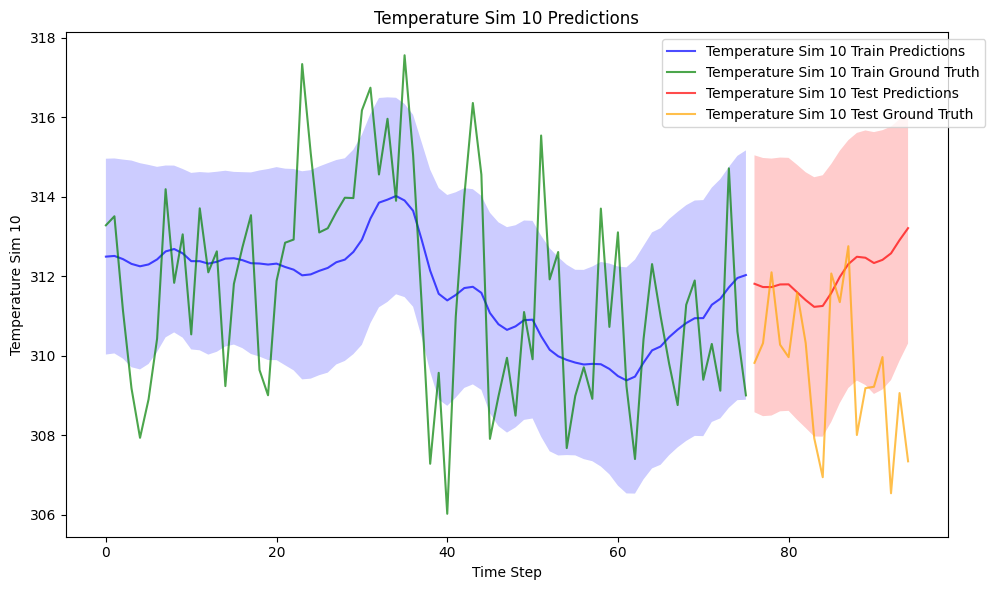

In [5]:
# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_mean, test_mean, y_train_orig, y_test_orig, 
                            feature_names, num_simulations=10, 
                            train_var = train_var, test_var = test_var)

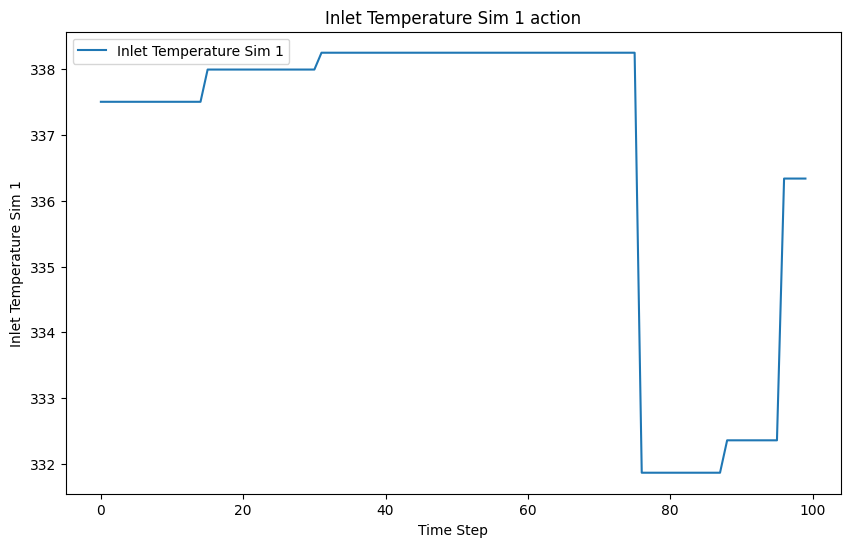

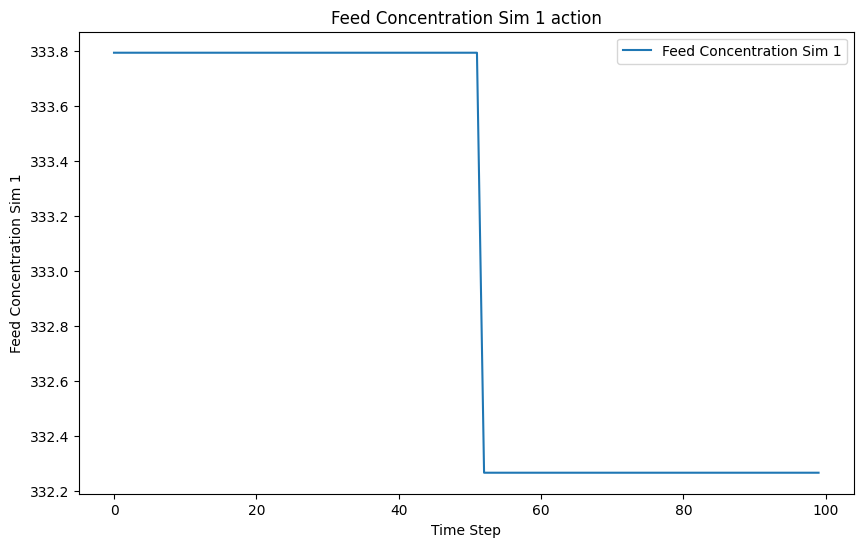

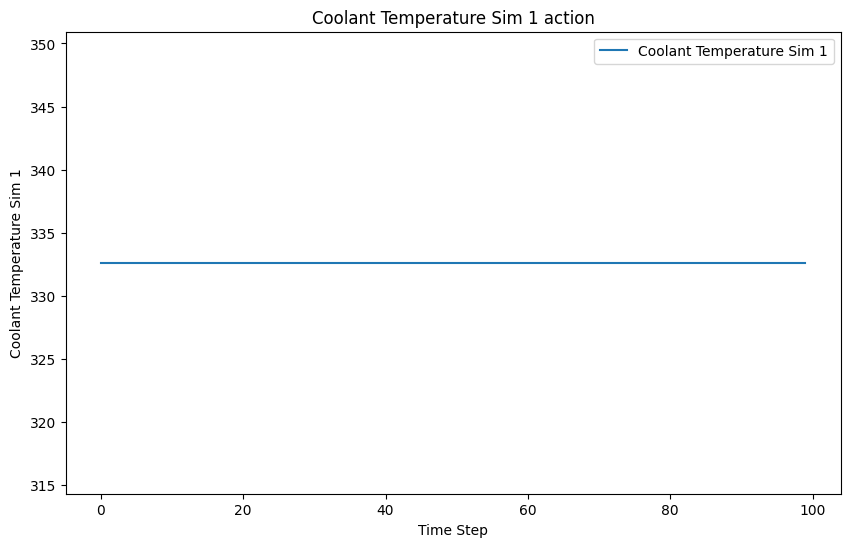

In [6]:
# Then we can plot this against the actions, to see the relationship between the actions/disturbances
# and the outputs
tgt_idxs = int((features.shape[1] - targets.shape[1]))
actions = features[:, -tgt_idxs:]
action_names = ['Inlet Temperature', 'Feed Concentration', 'Coolant Temperature']
# Use the plot actions class to compare the actions to the outputs
visualiser.plot_actions(actions, action_names, num_simulations=1)
# As there is no explicit control action, the setpoint is basically meaningless

We can also calculate the complexity of the model using the number of FLOPs

In [23]:
import fvcore
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in model.parameters())}")

Unsupported operator aten::adaptive_avg_pool1d encountered 1 time(s)


Number of FLOPs: 614240
Number of Model Params: 33679


Can use Bayesian Optimisation to find the best hyperparameters for the model

In [7]:
# First set the bounds for CNN Model
CNN_ConfigBounds = {
# Training config bounds
'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'num_epochs': (50, 500),
'learning_rate': (0.0001, 0.1),
'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'horizon': (1, 10),
'weight_decay': (1e-6, 0.1),
'factor': (0.1, 0.99),
'patience': (5, 100),
'delta': (1e-6, 0.1),      

# CNN specific bounds - much wider ranges
'conv_channels': [(8, 128), (16, 256)],  # Much wider range for channel sizes
'kernel_sizes': [(2, 9), (2, 7)],       # More kernel size options
'fc_dims': [(32, 512), (64, 1024)],     # Wider range for fully connected layers
'dropout': (0.0, 0.9)                    # Full range of dropout values
}


In [ ]:
# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardCNN, sim_config=CSTR_Config,
                              train_config=training_config, model_config=CNN_Config,
                              config_bounds=CNN_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

path = 'CSTR_CNN_NLL_Opt.pth'

best_params, best_loss = optimiser.optimise(path)
# The best performing model is saved automatically by the optimiser and can be loaded

Epoch [10/120], Train Loss: 0.1375, Test Loss: 0.1333, Avg Loss: 0.1354
Epoch [20/120], Train Loss: 0.0833, Test Loss: 0.1040, Avg Loss: 0.0937
Epoch [30/120], Train Loss: 0.0641, Test Loss: 0.0862, Avg Loss: 0.0752
Epoch [40/120], Train Loss: 0.0552, Test Loss: 0.0779, Avg Loss: 0.0665
Epoch [50/120], Train Loss: 0.0673, Test Loss: 0.0925, Avg Loss: 0.0799
Epoch [60/120], Train Loss: 0.0720, Test Loss: 0.0843, Avg Loss: 0.0781
Epoch [70/120], Train Loss: 0.0730, Test Loss: 0.0916, Avg Loss: 0.0823
Epoch [80/120], Train Loss: 0.0700, Test Loss: 0.0945, Avg Loss: 0.0822
Epoch [90/120], Train Loss: 0.0752, Test Loss: 0.0941, Avg Loss: 0.0846
Epoch [100/120], Train Loss: 0.0677, Test Loss: 0.0901, Avg Loss: 0.0789
Epoch [110/120], Train Loss: 0.0733, Test Loss: 0.0929, Avg Loss: 0.0831
Epoch [120/120], Train Loss: 0.0711, Test Loss: 0.0910, Avg Loss: 0.0810
Epoch [10/224], Train Loss: 0.0862, Test Loss: 0.0651, Avg Loss: 0.0756
Epoch [20/224], Train Loss: 0.0692, Test Loss: 2072.9614, Avg

Optimisation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/62], Train Loss: 0.0605, Test Loss: 4.6643, Avg Loss: 2.3624
Epoch [20/62], Train Loss: 0.0539, Test Loss: 0.0263, Avg Loss: 0.0401
Epoch [30/62], Train Loss: 0.0526, Test Loss: 0.0323, Avg Loss: 0.0424
Epoch [40/62], Train Loss: 0.0447, Test Loss: 0.0225, Avg Loss: 0.0336
Epoch [50/62], Train Loss: 0.0392, Test Loss: 0.0304, Avg Loss: 0.0348


Optimisation Progress:   5%|▌         | 1/20 [00:02<00:50,  2.64s/it, Loss=0.0574]

Epoch [60/62], Train Loss: 0.0522, Test Loss: 0.5931, Avg Loss: 0.3227
Epoch [10/425], Train Loss: 0.0765, Test Loss: 0.1646, Avg Loss: 0.1205
Epoch [20/425], Train Loss: 0.0656, Test Loss: 0.0820, Avg Loss: 0.0738
Epoch [30/425], Train Loss: 0.0777, Test Loss: 0.0627, Avg Loss: 0.0702
Epoch [40/425], Train Loss: 0.0740, Test Loss: 0.1039, Avg Loss: 0.0890
Epoch [50/425], Train Loss: 0.0848, Test Loss: 0.0973, Avg Loss: 0.0910
Epoch [60/425], Train Loss: 0.0838, Test Loss: 0.0969, Avg Loss: 0.0904
Epoch [70/425], Train Loss: 0.0884, Test Loss: 0.0931, Avg Loss: 0.0908
Epoch [80/425], Train Loss: 0.0907, Test Loss: 0.0943, Avg Loss: 0.0925
Epoch [90/425], Train Loss: 0.0897, Test Loss: 0.0936, Avg Loss: 0.0917
Epoch [100/425], Train Loss: 0.0916, Test Loss: 0.0932, Avg Loss: 0.0924
Epoch [110/425], Train Loss: 0.0925, Test Loss: 0.0950, Avg Loss: 0.0938
Epoch [120/425], Train Loss: 0.0898, Test Loss: 0.0934, Avg Loss: 0.0916
Epoch [130/425], Train Loss: 0.0939, Test Loss: 0.0946, Avg Lo

Optimisation Progress:  10%|█         | 2/20 [00:15<02:36,  8.71s/it, Loss=0.0574]

Epoch [420/425], Train Loss: 0.0905, Test Loss: 0.0942, Avg Loss: 0.0924
Epoch [10/252], Train Loss: 7.2855, Test Loss: 0.1557, Avg Loss: 3.7206
Epoch [20/252], Train Loss: 0.3124, Test Loss: 0.4833, Avg Loss: 0.3978
Epoch [30/252], Train Loss: 0.0925, Test Loss: 0.3543, Avg Loss: 0.2234
Epoch [40/252], Train Loss: 0.0525, Test Loss: 0.0660, Avg Loss: 0.0593
Epoch [50/252], Train Loss: 0.0557, Test Loss: 0.0561, Avg Loss: 0.0559
Epoch [60/252], Train Loss: 0.0492, Test Loss: 0.0591, Avg Loss: 0.0541
Epoch [70/252], Train Loss: 0.0525, Test Loss: 2.3640, Avg Loss: 1.2082
Epoch [80/252], Train Loss: 0.0563, Test Loss: 0.0611, Avg Loss: 0.0587
Epoch [90/252], Train Loss: 0.0451, Test Loss: 0.0604, Avg Loss: 0.0527
Epoch [100/252], Train Loss: 0.0519, Test Loss: 0.0530, Avg Loss: 0.0524
Epoch [110/252], Train Loss: 0.0513, Test Loss: 0.0632, Avg Loss: 0.0573
Epoch [120/252], Train Loss: 0.0532, Test Loss: 0.0555, Avg Loss: 0.0544
Epoch [130/252], Train Loss: 0.0491, Test Loss: 0.0561, Avg 

Optimisation Progress:  15%|█▌        | 3/20 [00:23<02:24,  8.48s/it, Loss=0.0571]

Epoch [250/252], Train Loss: 0.0426, Test Loss: 0.0624, Avg Loss: 0.0525
Epoch [10/248], Train Loss: 0.0464, Test Loss: 0.0592, Avg Loss: 0.0528
Epoch [20/248], Train Loss: 0.0434, Test Loss: 0.0408, Avg Loss: 0.0421
Epoch [30/248], Train Loss: 0.0427, Test Loss: 0.0414, Avg Loss: 0.0420
Epoch [40/248], Train Loss: 0.0443, Test Loss: 0.0447, Avg Loss: 0.0445
Epoch [50/248], Train Loss: 0.0445, Test Loss: 0.0485, Avg Loss: 0.0465
Epoch [60/248], Train Loss: 0.0457, Test Loss: 0.0477, Avg Loss: 0.0467
Epoch [70/248], Train Loss: 0.0458, Test Loss: 0.0459, Avg Loss: 0.0459
Epoch [80/248], Train Loss: 0.0451, Test Loss: 0.0407, Avg Loss: 0.0429
Epoch [90/248], Train Loss: 0.0444, Test Loss: 0.0448, Avg Loss: 0.0446
Epoch [100/248], Train Loss: 0.0445, Test Loss: 0.0425, Avg Loss: 0.0435
Epoch [110/248], Train Loss: 0.0451, Test Loss: 0.0449, Avg Loss: 0.0450
Epoch [120/248], Train Loss: 0.0456, Test Loss: 0.0436, Avg Loss: 0.0446
Epoch [130/248], Train Loss: 0.0466, Test Loss: 0.0472, Avg 

Optimisation Progress:  20%|██        | 4/20 [00:27<01:46,  6.66s/it, Loss=0.0455]

Epoch [240/248], Train Loss: 0.0452, Test Loss: 0.0428, Avg Loss: 0.0440
Epoch [10/351], Train Loss: 0.0348, Test Loss: 0.0608, Avg Loss: 0.0478
Epoch [20/351], Train Loss: 0.0392, Test Loss: 0.0595, Avg Loss: 0.0494
Epoch [30/351], Train Loss: 0.0371, Test Loss: 0.0637, Avg Loss: 0.0504
Epoch [40/351], Train Loss: 0.0378, Test Loss: 0.0620, Avg Loss: 0.0499
Epoch [50/351], Train Loss: 0.0386, Test Loss: 0.0700, Avg Loss: 0.0543
Epoch [60/351], Train Loss: 0.0356, Test Loss: 0.0659, Avg Loss: 0.0507
Epoch [70/351], Train Loss: 0.0403, Test Loss: 0.0638, Avg Loss: 0.0521
Epoch [80/351], Train Loss: 0.0409, Test Loss: 0.0670, Avg Loss: 0.0539
Epoch [90/351], Train Loss: 0.0379, Test Loss: 0.0654, Avg Loss: 0.0517
Epoch [100/351], Train Loss: 0.0388, Test Loss: 0.0714, Avg Loss: 0.0551
Epoch [110/351], Train Loss: 0.0393, Test Loss: 0.0652, Avg Loss: 0.0522
Epoch [120/351], Train Loss: 0.0389, Test Loss: 0.0676, Avg Loss: 0.0532
Epoch [130/351], Train Loss: 0.0390, Test Loss: 0.0618, Avg 

Optimisation Progress:  25%|██▌       | 5/20 [00:32<01:29,  5.93s/it, Loss=0.0455]

Epoch [340/351], Train Loss: 0.0392, Test Loss: 0.0657, Avg Loss: 0.0524
Epoch [350/351], Train Loss: 0.0369, Test Loss: 0.0684, Avg Loss: 0.0526
Epoch [10/409], Train Loss: 4.6681, Test Loss: 7006.4385, Avg Loss: 3505.5533
Epoch [20/409], Train Loss: 0.0703, Test Loss: 0.0627, Avg Loss: 0.0665
Epoch [30/409], Train Loss: 0.0589, Test Loss: 0.0621, Avg Loss: 0.0605
Epoch [40/409], Train Loss: 0.0545, Test Loss: 0.0639, Avg Loss: 0.0592
Epoch [50/409], Train Loss: 0.0603, Test Loss: 0.0681, Avg Loss: 0.0642
Epoch [60/409], Train Loss: 0.0667, Test Loss: 0.0878, Avg Loss: 0.0773
Epoch [70/409], Train Loss: 0.0712, Test Loss: 0.0915, Avg Loss: 0.0814
Epoch [80/409], Train Loss: 0.0766, Test Loss: 0.0913, Avg Loss: 0.0840
Epoch [90/409], Train Loss: 0.0833, Test Loss: 0.0911, Avg Loss: 0.0872
Epoch [100/409], Train Loss: 0.0859, Test Loss: 0.0907, Avg Loss: 0.0883
Epoch [110/409], Train Loss: 0.0882, Test Loss: 0.0913, Avg Loss: 0.0897
Epoch [120/409], Train Loss: 0.0930, Test Loss: 0.0913

Optimisation Progress:  30%|███       | 6/20 [00:50<02:20, 10.05s/it, Loss=0.0455]

Epoch [10/408], Train Loss: 0.1070, Test Loss: 2.8327, Avg Loss: 1.4698
Epoch [20/408], Train Loss: 0.0607, Test Loss: 3.8696, Avg Loss: 1.9652
Epoch [30/408], Train Loss: 0.0623, Test Loss: 0.6172, Avg Loss: 0.3397
Epoch [40/408], Train Loss: 0.0581, Test Loss: 0.0929, Avg Loss: 0.0755
Epoch [50/408], Train Loss: 0.0576, Test Loss: 0.0765, Avg Loss: 0.0670
Epoch [60/408], Train Loss: 0.0577, Test Loss: 0.0739, Avg Loss: 0.0658
Epoch [70/408], Train Loss: 0.0559, Test Loss: 0.0784, Avg Loss: 0.0671
Epoch [80/408], Train Loss: 0.0591, Test Loss: 0.0798, Avg Loss: 0.0694
Epoch [90/408], Train Loss: 0.0558, Test Loss: 0.0791, Avg Loss: 0.0675
Epoch [100/408], Train Loss: 0.0560, Test Loss: 0.0770, Avg Loss: 0.0665
Epoch [110/408], Train Loss: 0.0560, Test Loss: 0.0748, Avg Loss: 0.0654
Epoch [120/408], Train Loss: 0.0550, Test Loss: 0.0762, Avg Loss: 0.0656
Epoch [130/408], Train Loss: 0.0532, Test Loss: 0.0756, Avg Loss: 0.0644
Epoch [140/408], Train Loss: 0.0570, Test Loss: 0.0746, Avg 

Optimisation Progress:  35%|███▌      | 7/20 [01:09<02:48, 12.94s/it, Loss=0.0455]

Epoch [330/408], Train Loss: 0.0550, Test Loss: 0.0753, Avg Loss: 0.0652
Early Stopping
Epoch [10/160], Train Loss: 0.3918, Test Loss: 0.1333, Avg Loss: 0.2626
Epoch [20/160], Train Loss: 0.2914, Test Loss: 0.5097, Avg Loss: 0.4005
Epoch [30/160], Train Loss: 0.0577, Test Loss: 0.1573, Avg Loss: 0.1075
Epoch [40/160], Train Loss: 0.0446, Test Loss: 0.0953, Avg Loss: 0.0700
Epoch [50/160], Train Loss: 0.0413, Test Loss: 0.0839, Avg Loss: 0.0626
Epoch [60/160], Train Loss: 0.0367, Test Loss: 0.0981, Avg Loss: 0.0674
Epoch [70/160], Train Loss: 0.0385, Test Loss: 0.0899, Avg Loss: 0.0642
Epoch [80/160], Train Loss: 0.0374, Test Loss: 0.0950, Avg Loss: 0.0662
Epoch [90/160], Train Loss: 0.0375, Test Loss: 0.0894, Avg Loss: 0.0635
Epoch [100/160], Train Loss: 0.0409, Test Loss: 0.0879, Avg Loss: 0.0644
Epoch [110/160], Train Loss: 0.0379, Test Loss: 0.0951, Avg Loss: 0.0665
Epoch [120/160], Train Loss: 0.0388, Test Loss: 0.0940, Avg Loss: 0.0664
Epoch [130/160], Train Loss: 0.0416, Test Los

Optimisation Progress:  40%|████      | 8/20 [01:13<02:02, 10.17s/it, Loss=0.0455]

Epoch [10/194], Train Loss: 2.8158, Test Loss: 8024.4321, Avg Loss: 4013.6239
Epoch [20/194], Train Loss: 0.0740, Test Loss: 0.0568, Avg Loss: 0.0654
Epoch [30/194], Train Loss: 0.0567, Test Loss: 0.0444, Avg Loss: 0.0506
Epoch [40/194], Train Loss: 0.0857, Test Loss: 0.0443, Avg Loss: 0.0650
Epoch [50/194], Train Loss: 0.0580, Test Loss: 0.0453, Avg Loss: 0.0516
Epoch [60/194], Train Loss: 0.2154, Test Loss: 0.0440, Avg Loss: 0.1297
Epoch [70/194], Train Loss: 0.0535, Test Loss: 0.0424, Avg Loss: 0.0480
Epoch [80/194], Train Loss: 0.0592, Test Loss: 0.0424, Avg Loss: 0.0508
Epoch [90/194], Train Loss: 0.0542, Test Loss: 0.0427, Avg Loss: 0.0485
Epoch [100/194], Train Loss: 0.0540, Test Loss: 0.0422, Avg Loss: 0.0481
Epoch [110/194], Train Loss: 0.0529, Test Loss: 0.0422, Avg Loss: 0.0476
Epoch [120/194], Train Loss: 0.0512, Test Loss: 0.0420, Avg Loss: 0.0466
Epoch [130/194], Train Loss: 0.0545, Test Loss: 0.0431, Avg Loss: 0.0488
Epoch [140/194], Train Loss: 0.0543, Test Loss: 0.0424

After optimising the model, load the data

In [ ]:
# Load the optimised model
cp = torch.load(path)
print("Training configuration: ", cp['training_config'])
print("Model parameters: ", cp['model_config'])
model = CNN(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     var = True
                     )
model.load_state_dict(cp['model_state_dict'])
# Then find the complexity of the model
flops = FlopCountAnalysis(model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in model.parameters())}")

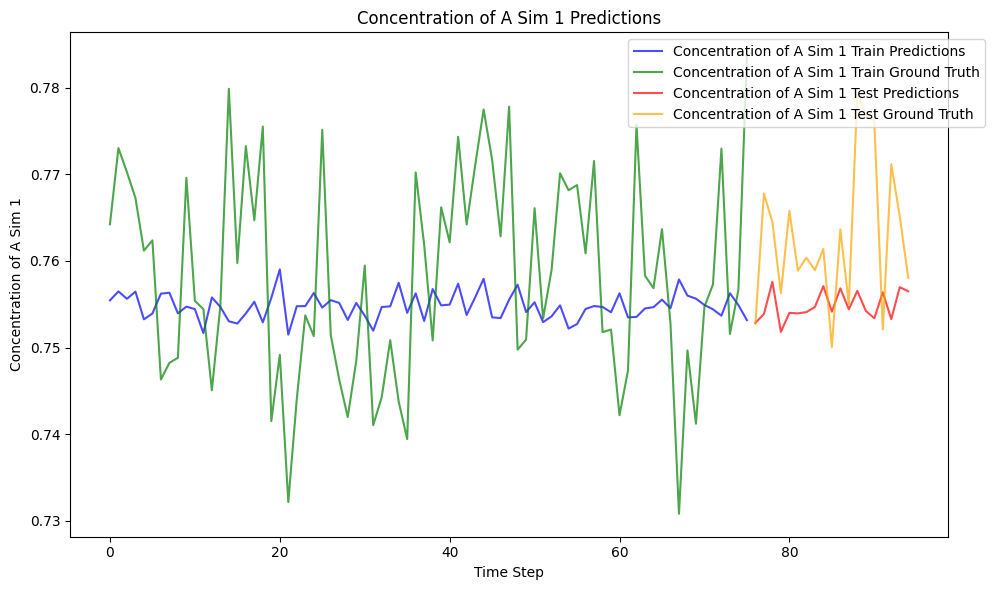

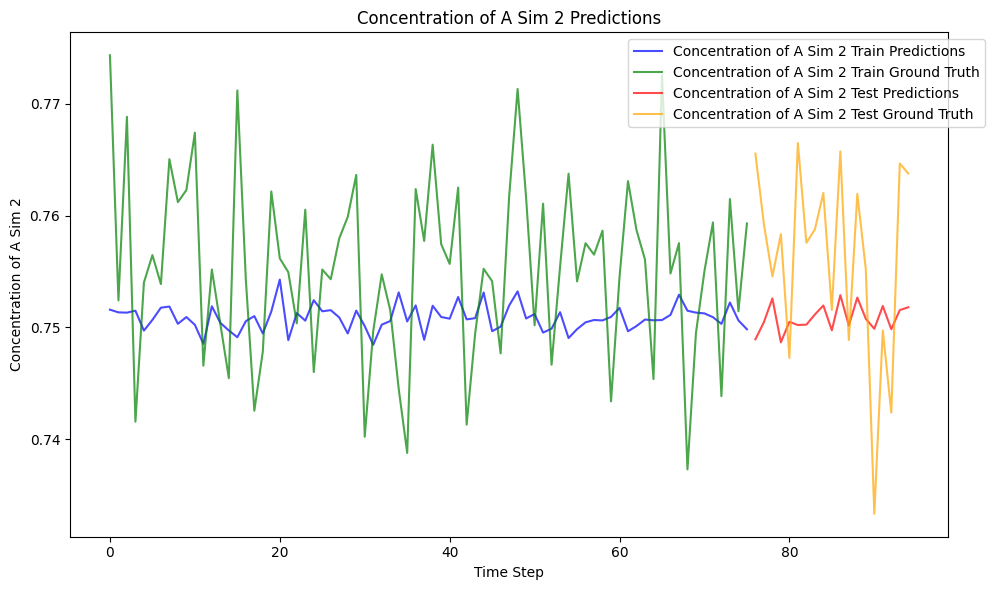

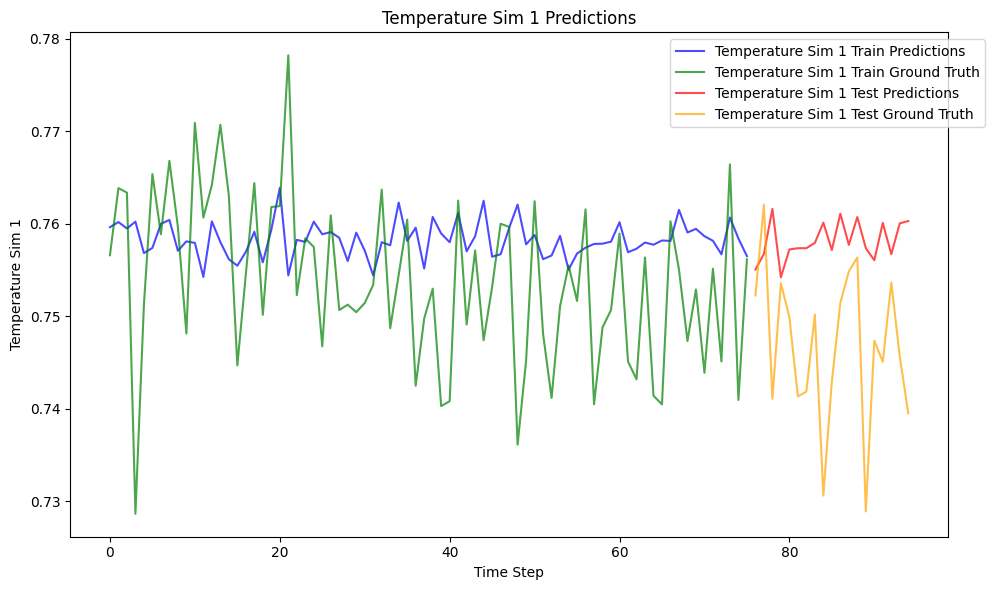

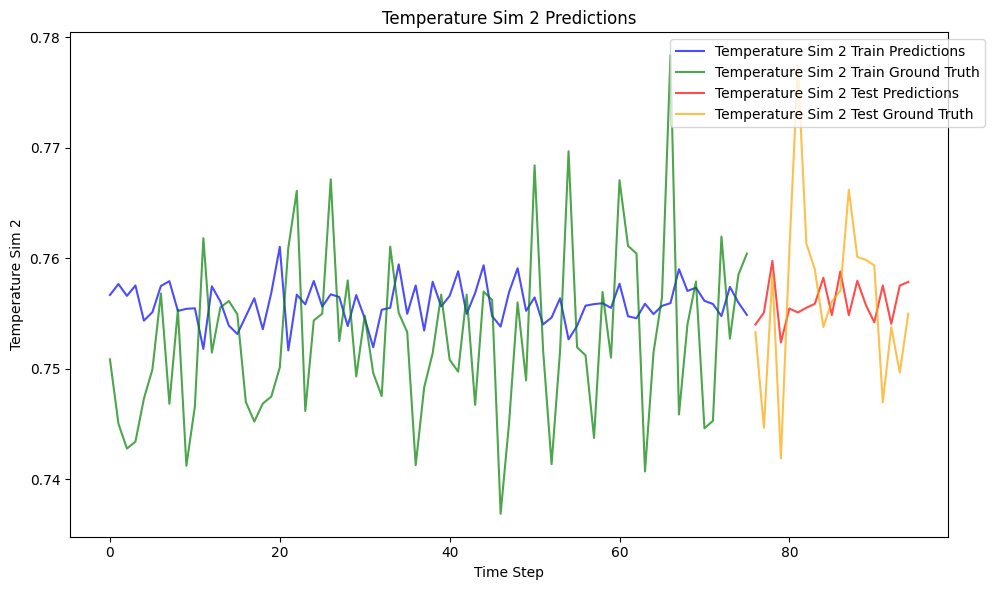

In [ ]:
model.eval()
with torch.no_grad():
    train_mean, train_var = model(X_train.to(training_config.device))
    test_mean, test_var = model(X_test.to(training_config.device))

# Transform the predictions back to the original
rescaled_train_pred = data_processor.process_model_output(train_mean, train_var)
train_mean = rescaled_train_pred.mean
train_var = rescaled_train_pred.variance

rescaled_test_pred = data_processor.process_model_output(test_mean, test_var)
test_mean = rescaled_test_pred.mean
test_var = rescaled_test_pred.variance


y_train_orig, y_test_orig = scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)

# Plot the optimised predictions of the model
visualiser.plot_predictions(train_mean, test_mean, y_train_orig, y_test_orig, 
                            feature_names, num_simulations=10, 
                            train_var=train_var, test_var=test_var)

#### Aleatoric Uncertainty - Non Parametric; Quantile Regression
Can also use a non parametric approach, using Quantile (Pinball) loss to find uncertainty bounds